In [48]:
import math, random, time, copy
import matplotlib.pyplot as plt
import csv
import numpy as np

变量说明：
'''
customers：编号+用户坐标
distances：由用户坐标计算得到
demands：用户编号+需求量
depots：仓库标号列表
capacity：最大供给能力
'''

In [49]:
def parse_cvrp_file(lines):
    customers = []
    distances = []
    demands = []
    depots = []
    capacity = None

    current_section = None
    for line in lines:
        line = line.strip()
        if line.startswith("CAPACITY"):
            capacity = int(line.split(":")[1].strip())
            continue
        elif line.startswith("NODE_COORD_SECTION"):
            current_section = "customers"
            continue
        elif line.startswith("DEMAND_SECTION"):
            current_section = "demands"
            continue
        elif line.startswith("DEPOT_SECTION"):
            current_section = "depots"
            continue
        elif line == "-1":
            current_section = None
            continue

        if current_section == "customers":
            parts = line.split()
            customers.append([int(parts[0]),int(float(parts[1])),int(float(parts[2]))])
        elif current_section == "demands":
            parts = line.split()
            demands.append([int(parts[0]),int(float(parts[1]))])
        elif current_section == "depots":
            parts = line.split()
            depots.append(int(parts[0]))
    for i in range(len(customers)):
        distances.append([])
        for j in range(len(customers)):
            if i<=j:
                distances[i].append(math.sqrt((customers[i][1]-customers[j][1])**2+(customers[i][2]-customers[j][2])**2))
            else:
                distances[i].append(distances[j][i])

    return customers, distances, demands, capacity, depots  # Excluding the last -1 from depots

# Example usage with file reading
# dataset_name = "gil262.vrp"
# dataset_name = "eilC76.vrp"
dataset_name = "eil51.vrp"
# dataset_name = "eilB101.vrp"    
with open(dataset_name, 'r') as city_data:
    lines = city_data.readlines()

customers, distances, demands, capacity, depots = parse_cvrp_file(lines)

In [4]:
# len(distances)
len(customers)
capacity
# demands
depots

[1]

In [50]:
class VRPGeneticAlgorithm:
    def __init__(self, customers, distances, demands, depots, capacity, population_size=50, mutation_rate=0.01, generations=1000):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = self.initial_population()
        self.best_solution = None
        self.best_distance = float('inf')
        self.fitness_history = []

    def initial_population(self):
        population = []
        for _ in range(self.population_size):
            solution = list(self.customers)
            random.shuffle(solution)
            population.append(solution)
        return population

    def calculate_distance(self, solution):
        total_distance = 0.0
        tmp = 0.0
        current_location = self.depots[0]  # Start from the depot

        for idx in range(len(solution)):
            customer_idx = solution[idx][0]

            # Check for valid index
            if 0 <= customer_idx - 1 < len(self.demands):
                tmp += self.demands[customer_idx - 1][1]  # Current demand

                if tmp > self.capacity:
                    # Return to depot and then go to the next customer
                    total_distance += self.distances[current_location - 1][self.depots[0] - 1]
                    total_distance += self.distances[self.depots[0] - 1][customer_idx - 1]
                    tmp = self.demands[customer_idx - 1][1]  # Reset the load
                    current_location = self.depots[0]
                else:
                    # Go directly to the next customer
                    total_distance += self.distances[current_location - 1][customer_idx - 1]
                    current_location = customer_idx
            else:
                print(f"Invalid index: {customer_idx - 1}")

        # Return to depot after the last customer
        total_distance += self.distances[current_location - 1][self.depots[0] - 1]

        return total_distance



    def fitness(self, solution):
        return self.calculate_distance(solution)

    def selection(self):
        sorted_population = sorted(self.population, key=self.fitness)
        return sorted_population[:2]  # Return top 2 solutions

    def crossover(self, parent1, parent2):
        child = [None] * len(parent1)

        # Step 1: Select a subset of the first parent
        start, end = sorted(random.sample(range(len(parent1)), 2))

        # Step 2: Copy this subset to the child
        child[start:end] = parent1[start:end]

        # Step 3: Fill the remaining positions with genes from the second parent
        parent2_idx = 0
        for i in range(len(child)):
            if child[i] is None:
                while parent2[parent2_idx] in child:
                    parent2_idx += 1
                child[i] = parent2[parent2_idx]

        return child

    def mutate(self, solution):
        for i in range(len(solution)):
            if random.random() < self.mutation_rate:
                j = random.randint(0, len(solution) - 1)
                solution[i], solution[j] = solution[j], solution[i]
        return solution

    def evolve(self):
        new_population = []
        for _ in range(self.population_size):
            parent1, parent2 = self.selection()
            offspring = self.crossover(parent1, parent2)
            offspring = self.mutate(offspring)
            new_population.append(offspring)

        self.population = new_population

    def run(self):
        for _ in range(self.generations):
            self.evolve()
            current_best = min(self.population, key=self.fitness)
            current_best_distance = self.fitness(current_best)
            if current_best_distance < self.best_distance:
                self.best_distance = current_best_distance
                self.best_solution = current_best
            self.fitness_history.append(self.best_distance)
        return self.best_solution, self.best_distance, self.fitness_history


In [53]:
ga = VRPGeneticAlgorithm(customers, distances, demands, depots, capacity, population_size=50, mutation_rate=0.01, generations=1000)
best_solution, best_distance, fitness_history = ga.run()

In [54]:
best_distance

639.6603933946718

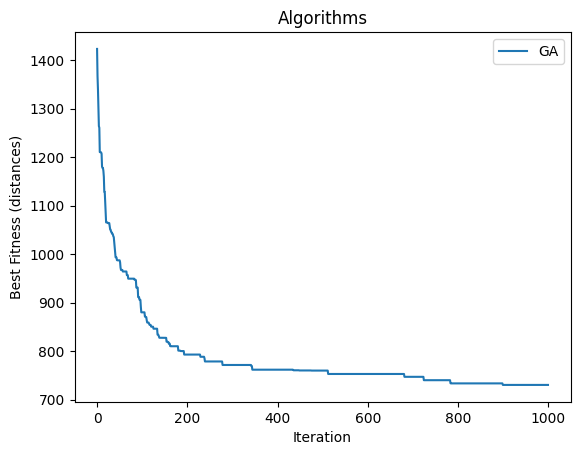

In [50]:
# Plot the Convergence Curve
plt.plot(fitness_history,label = 'GA')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [143]:
class VRP_PSO:
    def __init__(self, customers, distances, demands, depots, capacity, num_particles=30, max_iter=100, w=0.5, c1=1, c2=2):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient

        self.n = len(customers)
        self.particles = [self.initial_solution() for _ in range(num_particles)]
        self.best_particle_positions = list(self.particles)
        self.best_particle_distances = [self.calculate_distance(p) for p in self.particles]
        self.global_best_particle = min(self.best_particle_positions, key=lambda p: self.calculate_distance(p))
        self.global_best_distance = self.calculate_distance(self.global_best_particle)
        self.fitness_history = []

    def initial_solution(self):
        # Generate initial solution (route) for a particle
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        while unvisited:
            current = random.choice(unvisited)
            solution.append(current)
            unvisited.remove(current)
        solution.insert(0, self.depots[0])
        solution.append(self.depots[0])
        return solution
    
    def calculate_distance(self, solution):
        total_distance = 0.0
        tmp = 0.0
        for idx in range(1,len(solution)-1):
            
            tmp += self.demands[solution[idx]-1][1] # current demand 
            if tmp>self.capacity:
                # if tmp // self.capacity>1:
                #     tmp = 
                tmp = self.demands[solution[idx]-1][1]
                total_distance += self.distances[solution[idx-1]-1][self.depots[0]-1]
                total_distance += self.distances[self.depots[0]-1][solution[idx]-1]
            else:
                total_distance += self.distances[solution[idx-1]-1][solution[idx]-1]
        
        return total_distance

    def update_velocity_position(self, particle, best_particle_position, global_best_particle):
        new_particle = particle.copy()
        for i in range(1, len(particle) - 1):  # Exclude depots
            if random.random() < self.w + self.c1 * random.random() + self.c2 * random.random():
                swap_index = best_particle_position.index(particle[i])
                new_particle[i], new_particle[swap_index] = new_particle[swap_index], new_particle[i]

                swap_index = global_best_particle.index(particle[i])
                new_particle[i], new_particle[swap_index] = new_particle[swap_index], new_particle[i]

        return new_particle

    def solve(self):
        for _ in range(self.max_iter):
            for i in range(self.num_particles):
                self.particles[i] = self.update_velocity_position(self.particles[i], self.best_particle_positions[i], self.global_best_particle)
                current_distance = self.calculate_distance(self.particles[i])

                if current_distance < self.best_particle_distances[i]:
                    self.best_particle_positions[i] = self.particles[i]
                    self.best_particle_distances[i] = current_distance

                    if current_distance < self.global_best_distance:
                        self.global_best_particle = self.particles[i]
                        self.global_best_distance = current_distance
            self.fitness_history.append(self.global_best_distance)

        return self.global_best_particle, self.global_best_distance, self.fitness_history


In [138]:
#0.3 1 2
pso = VRP_PSO(customers, distances, demands, depots, capacity, num_particles=1500, max_iter=1000, w=0.3, c1=1, c2=2)
best_solution, best_distance, fitness_history = pso.solve()
best_distance

652.5677944135075

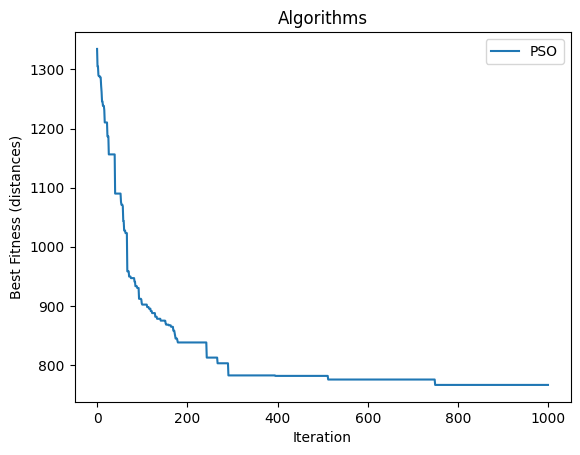

In [279]:
# Plot the Convergence Curve
pso = VRP_PSO(customers, distances, demands, depots, capacity, num_particles=1500, max_iter=1000, w=0.3, c1=1, c2=2)
best_solution, best_distance, fitness_history = pso.solve()
plt.plot(fitness_history, label = 'PSO')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

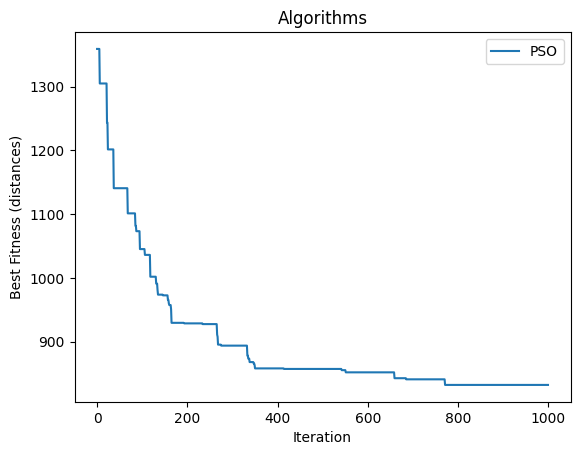

In [199]:
# Plot the Convergence Curve
plt.plot(fitness_history, label = 'PSO')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [17]:
distances_aco = np.array(distances)
demands_aco = np.array([d[1] for d in demands])

In [18]:
class ACO:
    def __init__(self, distance_matrix, demands, depot_index, vehicle_capacity, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_intensity):
        self.distance_matrix = distance_matrix
        self.demands = demands
        self.depot_index = depot_index  
        self.vehicle_capacity = vehicle_capacity
        self.num_customers = distance_matrix.shape[0]
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensity = pheromone_intensity
        self.pheromone_matrix = np.ones(self.distance_matrix.shape)

    def calculate_probabilities(self, current_location, visited):
        """计算从当前位置到其他位置的转移概率"""
        pheromone_levels = self.pheromone_matrix[current_location, :]
        visibility = 1 / (self.distance_matrix[current_location, :] + 1e-10)  # avoid 0
        mask = np.ones(self.num_customers, dtype=bool)  # ingore the visited
        mask[list(visited)] = False
        probabilities = (pheromone_levels ** self.alpha) * (visibility ** self.beta) * mask
        probabilities /= np.sum(probabilities)
        return probabilities

    def select_next_customer(self, probabilities):
        """根据概率选择下一个客户"""
        return np.random.choice(range(self.num_customers), p=probabilities)

    def run(self):
        best_route = None
        best_distance = float('inf')
        fitness_history = []

        for iteration in range(self.num_iterations):
            for ant in range(self.num_ants):
                route = [self.depot_index]   
                visited = set([self.depot_index])  
                current_capacity = self.vehicle_capacity
                current_location = self.depot_index

                while len(visited) < self.num_customers:
                    probabilities = self.calculate_probabilities(current_location, visited)
                    next_location = self.select_next_customer(probabilities)

                    if next_location != self.depot_index and self.demands[next_location] <= current_capacity and next_location not in visited:
                        route.append(next_location)
                        visited.add(next_location)
                        current_capacity -= self.demands[next_location]
                        current_location = next_location
                    else:
                        # back to depot and reload
                        if current_location != self.depot_index:
                            route.append(self.depot_index)
                            current_capacity = self.vehicle_capacity
                            route.append(next_location)
                            visited.add(next_location)
                            current_capacity -= self.demands[next_location]
                            current_location = next_location

                
                route_distance = sum(self.distance_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

                
                if route_distance < best_distance:
                    best_distance = route_distance
                    best_route = route
            fitness_history.append(best_distance)

            # update pheromone matrix
            self.pheromone_matrix *= (1 - self.evaporation_rate)
            for r in range(len(best_route) - 1):
                self.pheromone_matrix[best_route[r], best_route[r+1]] += self.pheromone_intensity / best_distance

        return best_route, best_distance, fitness_history

In [114]:
vehicle_capacity=capacity
depot_index = 0
num_ants=50
num_iterations=100
alpha=0.1
beta=1.0
evaporation_rate=0.995
pheromone_intensity=1.0
aco = ACO(distances_aco, demands_aco, depot_index, vehicle_capacity, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_intensity)
best_route, best_distance, fitness_history = aco.run()

In [253]:
vehicle_capacity=capacity
depot_index = 0
num_ants=50
num_iterations=100
alpha=0.1
beta=2
evaporation_rate=0.995
pheromone_intensity=1.0
aco = ACO(distances_aco, demands_aco, depot_index, vehicle_capacity, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_intensity)
best_route, best_distance, fitness_history = aco.run()
best_distance

641.6167003455931

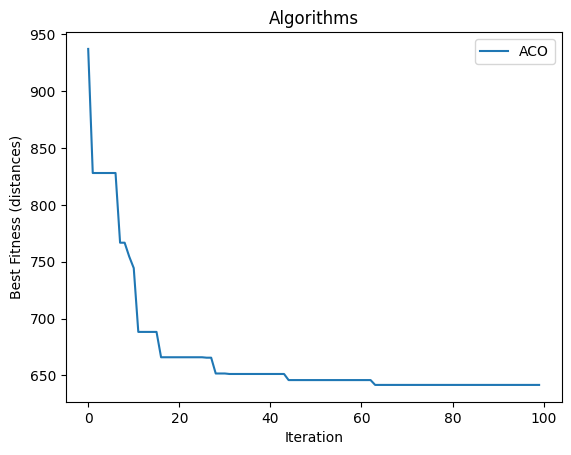

In [254]:
# Plot the Convergence Curve
plt.plot(fitness_history, label = 'ACO')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [151]:
'''先计算TSP再分断'''
class CVRPTabuSearch:
    def __init__(self, customers, distances, demands, depots, capacity, tab_length, max_iterations=1000):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.n= len(customers)
        self.max_iterations = max_iterations
        self.tabu_list = [([0] * self.n) for i in range(self.n)]
        # self.tab_length = int(self.n //5 )
        self.tab_length = tab_length
        self.best_solution = self.initial_solution(mode='random')
        self.best_distance = self.calculate_distance(self.best_solution)
        self.fitness_history = []

    def initial_solution(self, mode="random"):
        # 使用贪婪算法或其他方法生成初始解
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        count = len(unvisited)
        solution.append(self.depots[0])
        while(count!=0):
            index = random.randint(0, count - 1)
            current = unvisited[index]
            solution.append(current)
            unvisited.remove(current)
            count -= 1
        solution.append(self.depots[0])
        return solution
    
    def generate_neighborhood(self, solution):
        neighborhood = []
        for i in range(1, len(solution) - 1):  # 不包括仓库
            for j in range(i + 1, len(solution) - 1):  # 不包括仓库
                if i != j:
                    neighbor = solution[:]  # 复制解    
                    # 交换两个节点的位置
                    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                    yield neighbor, (i, j)

        

    def calculate_distance(self, solution):
        # 计算解的总距离
        total_distance = 0.0
        tmp = 0.0
        for idx in range(1,len(solution)-1):
            
                
            tmp += self.demands[solution[idx]-1][1] # current demand 
            if tmp>self.capacity:
                # if tmp // self.capacity>1:
                #     tmp = 
                tmp = self.demands[solution[idx]-1][1]
                total_distance += self.distances[solution[idx-1]-1][self.depots[0]-1]
                total_distance += self.distances[self.depots[0]-1][solution[idx]-1]
            else:
                total_distance += self.distances[solution[idx-1]-1][solution[idx]-1]
        
        return total_distance
        

    def update_tabu_list(self, move):
        # 更新禁忌列表
        for i in range(self.n):
            for j in range(self.n-i):
                if self.tabu_list[i][j] != 0:
                    self.tabu_list[i][j] -= 1
        self.tabu_list[move[0]][move[1]] = self.tab_length
        # pass

    def is_tabu(self, move):
        # 判断操作是否在禁忌列表中
        # return move in self.tabu_list
        return self.tabu_list[move[0]][move[1]] != 0
        # pass

    def search(self):
        for _ in range(self.max_iterations):
            neighborhood = self.generate_neighborhood(self.best_solution)
            for neighbor, move in neighborhood:
                if not self.is_tabu(move) :
                    distance = self.calculate_distance(neighbor)
                    if distance < self.best_distance:
                        self.best_solution = neighbor
                        self.best_distance = distance
                        self.update_tabu_list(move)
                # self.fitness_history.append(self.best_distance)
            self.fitness_history.append(self.best_distance)
            # self.solution = self.best_solution
        return self.best_solution, self.best_distance, self.fitness_history

In [103]:
#### Tabu Search ####
# ts = CVRPTabuSearch(customers, distances, demands, depots, capacity, max_iterations=40)
ts = CVRPTabuSearch(customers, distances, demands, depots, capacity, max_iterations=1000)
best_solution, best_distance, fitness_history = ts.search()

In [160]:
ts = CVRPTabuSearch(customers, distances, demands, depots, capacity, tab_length=5, max_iterations=1000)
best_solution, best_distance, fitness_history = ts.search()
best_distance

662.6819752721783

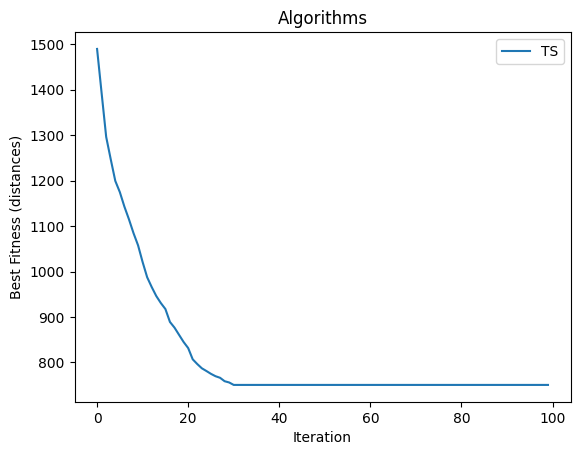

In [241]:
ts = CVRPTabuSearch(customers, distances, demands, depots, capacity, tab_length=5, max_iterations=100)
best_solution, best_distance, fitness_history = ts.search()
plt.plot(fitness_history,label = 'TS')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [162]:
best_distance

674.1286658422806

In [89]:
class CVRPSimulatedAnnealing:
    def __init__(self, customers, distances, demands, depots, capacity, T=1000, alpha=0.995, stopping_T=1e-8, stopping_iter=100000):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.T = T
        self.alpha = alpha
        self.stopping_T = stopping_T
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.n = len(customers)
        self.initial_solution = self.initial_solution()
        self.best_solution = list(self.initial_solution)
        self.best_distance = self.calculate_distance(self.best_solution)

    def initial_solution(self):
        # 使用贪婪算法或其他方法生成初始解
        # ...
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        count = len(unvisited)
        solution.append(self.depots[0])
        while(count!=0):
            index = random.randint(0, count - 1)
            current = unvisited[index]
            solution.append(current)
            unvisited.remove(current)
            count -= 1
        solution.append(self.depots[0])
        return solution

    def calculate_distance(self, solution):
        # 计算解的总距离
        # ...
        total_distance = 0.0
        tmp = 0.0
        for idx in range(1,len(solution)-1):
            
                
            tmp += self.demands[solution[idx]-1][1] # current demand 
            if tmp>self.capacity:
                # if tmp // self.capacity>1:
                #     tmp = 
                tmp = self.demands[solution[idx]-1][1]
                total_distance += self.distances[solution[idx-1]-1][self.depots[0]-1]
                total_distance += self.distances[self.depots[0]-1][solution[idx]-1]
            else:
                total_distance += self.distances[solution[idx-1]-1][solution[idx]-1]
        
        return total_distance

    def accept_probability(self, candidate_distance):
        return math.exp(-abs(candidate_distance - self.best_distance) / self.T)

    def accept(self, candidate_solution):
        candidate_distance = self.calculate_distance(candidate_solution)
        if candidate_distance < self.best_distance:
            self.best_distance, self.best_solution = candidate_distance, candidate_solution
        else:
            if random.random() < self.accept_probability(candidate_distance):
                self.best_distance, self.best_solution = candidate_distance, candidate_solution

    def anneal(self):
        fitness_history=[self.best_distance]
        while self.T >= self.stopping_T and self.iteration < self.stopping_iter:
            candidate_solution = list(self.best_solution)
            l = random.randint(2, self.n - 1)
            i = random.randint(1, self.n - l)

            candidate_solution[i : (i + l)] = reversed(candidate_solution[i : (i + l)])

            self.accept(candidate_solution)
            fitness_history.append(self.best_distance)
            self.T *= self.alpha
            self.iteration += 1

        return self.best_solution, self.best_distance, fitness_history

In [170]:
sa = CVRPSimulatedAnnealing(customers, distances, demands, depots, capacity, T=1000, alpha=0.995, stopping_T=1e-8, stopping_iter=100000)
best_solution, best_distance, fitness_history = sa.anneal()
best_distance

691.9093215973021

In [193]:
best_distance

574.7946529047044

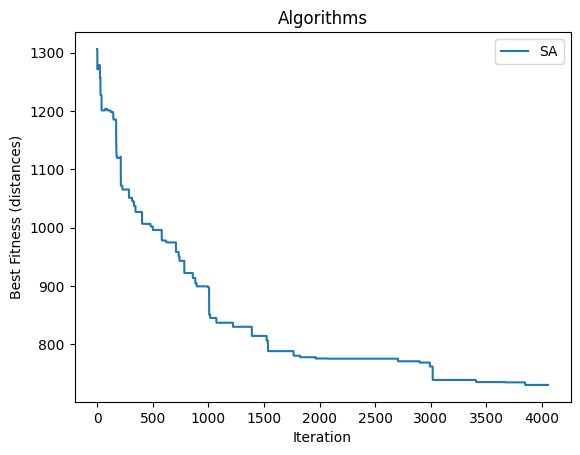

In [240]:
sa = CVRPSimulatedAnnealing(customers, distances, demands, depots, capacity, T=1000, alpha=0.995, stopping_T=1e-8, stopping_iter=100000000)
best_solution, best_distance, fitness_history = sa.anneal()
# Plot the Convergence Curve
plt.plot(fitness_history[1000:],label = 'SA')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

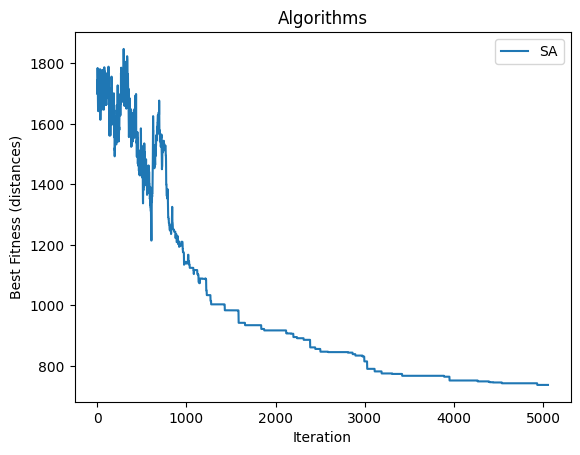

In [138]:
# Plot the Convergence Curve
plt.plot(fitness_history,label = 'SA')
plt.title('Algorithms')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()